1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

file_name = "data_000637.txt"
df = pd.read_csv(file_name)
N = int(input("Choose number of rows: "))
if N < df.shape[0]+1 and N > 10000:
    dataset = df[(df.index<N)]
    print(dataset)
else:
    raise ValueError("Number of rows is too small or too big!!!")

Choose number of rows: 100000
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
99995     1     0           64  3869201161        2378        29
99996     1     0           70  3869201161        2472        26
99997     1     0           58  3869201161        2558         0
99998     1     0           57  3869201161        2561        23
99999     1     0           56  3869201161        2565        12

[100000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [2]:
numb_bx = dataset['BX_COUNTER'].max()+1
print("The number of BX in an ORBIT is: ",numb_bx)

The number of BX in an ORBIT is:  3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [3]:
df['time'] = (df['ORBIT_CNT']*numb_bx + df['BX_COUNTER'])*25+ df['TDC_MEAS']*25/30
print("My new dataframe is: \n", df)
df["time series"] = pd.to_datetime(df["time"])
print("My time series is: \n",df["time series"])

My new dataframe is: 
          HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0           1     0          123  3869200167        2374        26   
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
...       ...   ...          ...         ...         ...       ...   
1310715     1     0           62  3869211171         762        14   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

                 time  
0        3.447457e+14  
1        3.447457e+14  
2        3.447457e+14  
3        3.447457e+14  
4        3.44745

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [4]:
df['DURATION_MEASUREMENT'] = pd.to_timedelta(df['time'])

print("\nThe duration of the whole data taking:\n", (df['DURATION_MEASUREMENT'].max() - df['DURATION_MEASUREMENT'].min()))


The duration of the whole data taking:
 0 days 00:00:00.980416254


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [5]:
channel = dataset[['HEAD','TDC_CHANNEL']].groupby(['TDC_CHANNEL']).count().sort_values(['HEAD'], ascending=False)
print("The 3 most noisy channels are:\n ",channel.head(3))

The 3 most noisy channels are:
               HEAD
TDC_CHANNEL      
139          8320
64           5027
63           4917


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [6]:
print("Number of non-empty orbits: ",len(dataset["ORBIT_CNT"].unique()))

Number of non-empty orbits:  995


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [7]:
print("Number of unique orbits with at least one measurement from TDC_CHANNEL=139: ",len(dataset[dataset["TDC_CHANNEL"] == 139]["ORBIT_CNT"].unique()))

Number of unique orbits with at least one measurement from TDC_CHANNEL=139:  994


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [8]:
FPGA0 = dataset[dataset["FPGA"] == 0].groupby("TDC_CHANNEL")["HEAD"].sum()
FPGA1 = dataset[dataset["FPGA"] == 1].groupby("TDC_CHANNEL")["HEAD"].sum()
print("Pandas series with FPGA = 0:\n ",FPGA0)
print()
print("Pandas series with FPGA = 1:\n ",FPGA1)

Pandas series with FPGA = 0:
  TDC_CHANNEL
1        91
2       109
3       118
4       148
5       121
       ... 
124    1312
130       2
137       2
138       2
139    5831
Name: HEAD, Length: 121, dtype: int64

Pandas series with FPGA = 1:
  TDC_CHANNEL
1      2116
2      2444
3      1670
4      2014
5      1151
       ... 
129       2
130       4
137       2
138       2
139    2489
Name: HEAD, Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

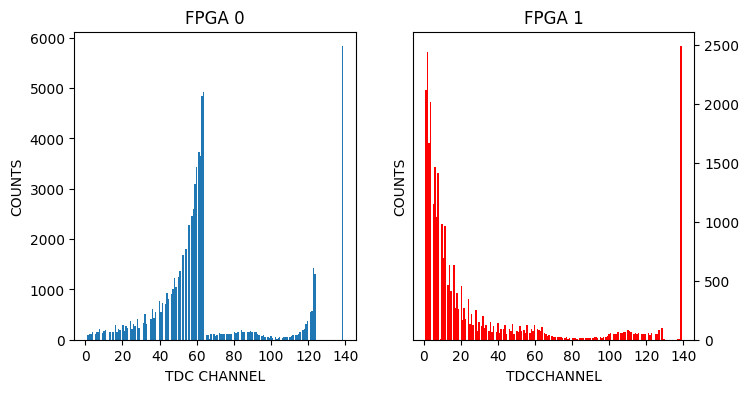

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

tdc0 = dataset[dataset['FPGA'] == 0]['TDC_CHANNEL']
tdc1 = dataset[dataset['FPGA'] == 1]['TDC_CHANNEL']
###########################################################
ax0.hist(tdc0, bins=175, label=('TDC CHANNEL', 'COUNTS'))
ax0.set_title('FPGA 0')
ax0.set_xlabel('TDC CHANNEL')
ax0.set_ylabel('COUNTS')
ax0.set_xticks(np.arange(0,max(tdc1)+20,20.0))  
############################################################
ax1.hist(tdc1, bins=175, label=('TDC CHANNEL', 'COUNTS'),color='red')
ax1.set_title('FPGA 1')
ax1.set_xlabel('TDCCHANNEL')
ax1.set_ylabel('COUNTS')
ax1.yaxis.tick_right()
ax1.set_xticks(np.arange(0,max(tdc1)+20,20.0)) 